In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    Dropout,
    Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



In [10]:
image_shape = (224, 224)
batch_size   = 32
epochs       = 10

data_path    = r'C:/Users/Ania/Desktop/dataset2/archive (1)/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_folder = os.path.join(data_path, 'train')
valid_folder = os.path.join(data_path, 'valid')
test_folder  = os.path.join(data_path, 'test')

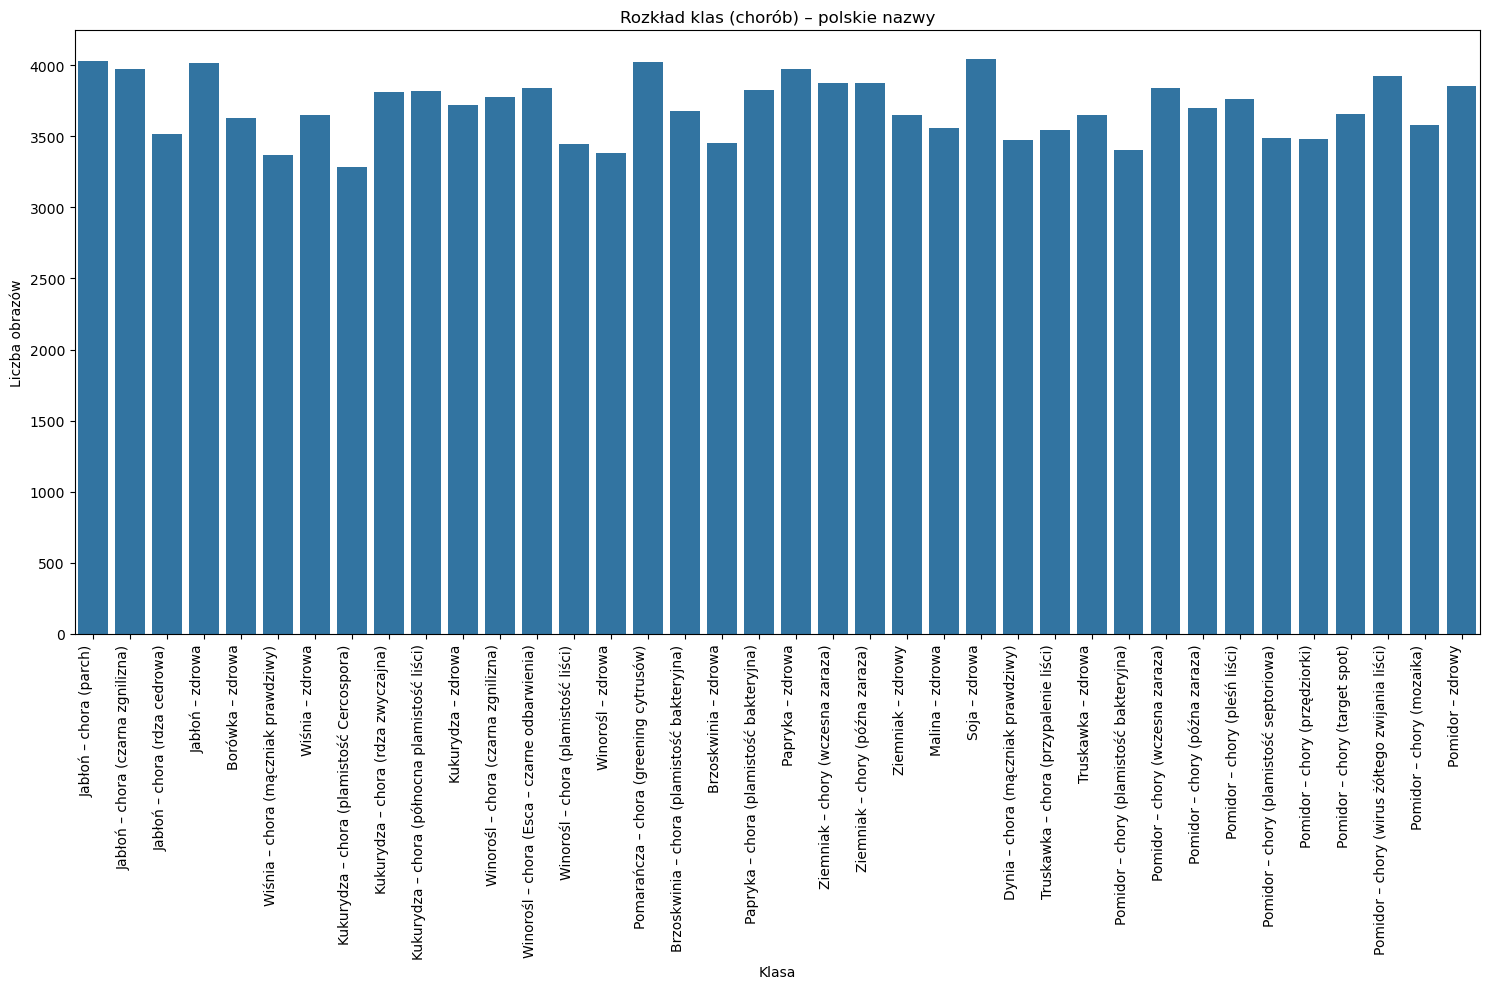

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pobranie i posortowanie listy folderów z nazwami klas (angielskie nazwy folderów)
diseases = sorted(os.listdir(train_folder))

# 2. Lista polskich nazw klas w tej samej kolejności co sorted(diseases)
class_names = [
    'Jabłoń – chora (parch)', 'Jabłoń – chora (czarna zgnilizna)', 'Jabłoń – chora (rdza cedrowa)', 'Jabłoń – zdrowa',
    'Borówka – zdrowa', 'Wiśnia – chora (mączniak prawdziwy)', 'Wiśnia – zdrowa',
    'Kukurydza – chora (plamistość Cercospora)', 'Kukurydza – chora (rdza zwyczajna)',
    'Kukurydza – chora (północna plamistość liści)', 'Kukurydza – zdrowa',
    'Winorośl – chora (czarna zgnilizna)', 'Winorośl – chora (Esca – czarne odbarwienia)',
    'Winorośl – chora (plamistość liści)', 'Winorośl – zdrowa',
    'Pomarańcza – chora (greening cytrusów)', 'Brzoskwinia – chora (plamistość bakteryjna)',
    'Brzoskwinia – zdrowa', 'Papryka – chora (plamistość bakteryjna)', 'Papryka – zdrowa',
    'Ziemniak – chory (wczesna zaraza)', 'Ziemniak – chory (późna zaraza)', 'Ziemniak – zdrowy',
    'Malina – zdrowa', 'Soja – zdrowa', 'Dynia – chora (mączniak prawdziwy)',
    'Truskawka – chora (przypalenie liści)', 'Truskawka – zdrowa',
    'Pomidor – chory (plamistość bakteryjna)', 'Pomidor – chory (wczesna zaraza)', 'Pomidor – chory (późna zaraza)',
    'Pomidor – chory (pleśń liści)', 'Pomidor – chory (plamistość septoriowa)',
    'Pomidor – chory (przędziorki)', 'Pomidor – chory (target spot)',
    'Pomidor – chory (wirus żółtego zwijania liści)', 'Pomidor – chory (mozaika)', 'Pomidor – zdrowy'
]

# Sprawdźmy, czy liczba folderów i liczba polskich nazw się zgadza
assert len(diseases) == len(class_names), "Lista polskich nazw musi mieć tyle samo elementów, co lista folderów."

# 3. Wyliczenie liczby obrazów w każdej klasie
class_counts = {}
for idx, cls in enumerate(diseases):
    path = os.path.join(train_folder, cls)
    # Zakładam, że w folderze są tylko pliki obrazów (jpg/png), bez podkatalogów
    count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    class_counts[class_names[idx]] = count

# 4. Przygotowanie DataFrame do wykresu
df = pd.DataFrame({
    "Klasa": list(class_counts.keys()),
    "Liczba obrazów": list(class_counts.values())
})

# 5. Rysowanie wykresu słupkowego
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x="Klasa", y="Liczba obrazów")
plt.xticks(rotation=90, ha="right")
plt.title("Rozkład klas (chorób) – polskie nazwy")
plt.tight_layout()
plt.show()


ValueError: num must be an integer with 1 <= num <= 9, not 10

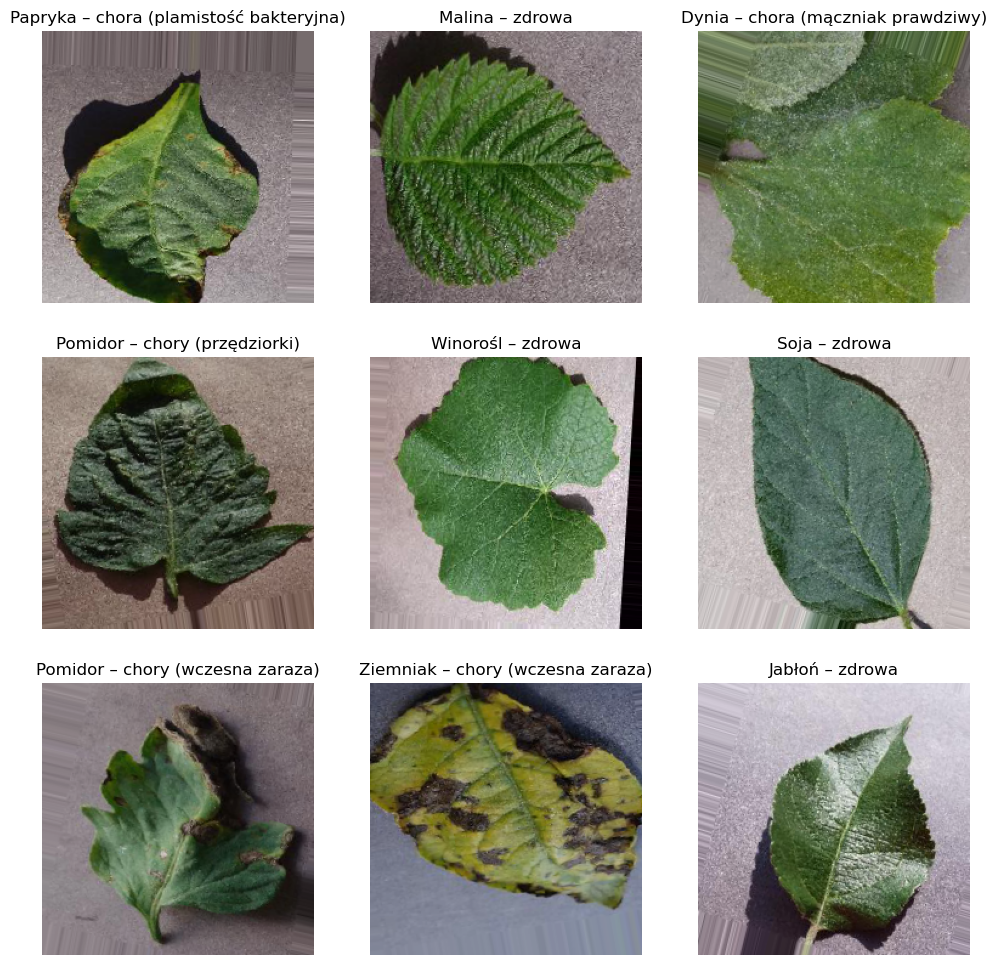

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt

# 1. Pobranie mapowania angielskich nazw klas na indeksy (np. {'Apple___scab': 0, 'Apple___healthy': 1, ...})
class_indices = train_data.class_indices  

# 2. Stworzenie odwrotnego słownika: indeks -> angielska nazwa
idx_to_english = {v: k for k, v in class_indices.items()}

# 3. Zdefiniowanie mapowania "angielska_nazwa" -> "polska_nazwa"
#    Klucze tego słownika muszą dokładnie odpowiadać nazwom katalogów (angielskim) użytym w train_data.
english_to_polish = {
    'Apple___Apple_scab': 'Jabłoń – chora (parch)',
    'Apple___Black_rot': 'Jabłoń – chora (czarna zgnilizna)',
    'Apple___Cedar_apple_rust': 'Jabłoń – chora (rdza cedrowa)',
    'Apple___healthy':     'Jabłoń – zdrowa',
    'Blueberry___healthy': 'Borówka – zdrowa',
    'Cherry___Powdery_mildew':       'Wiśnia – chora (mączniak prawdziwy)',
    'Cherry___healthy':               'Wiśnia – zdrowa',
    'Corn___Cercospora_leaf_spot Gray_leaf_spot': 'Kukurydza – chora (plamistość Cercospora)',
    'Corn___Common_rust_':             'Kukurydza – chora (rdza zwyczajna)',
    'Corn___Northern_Leaf_Blight':     'Kukurydza – chora (północna plamistość liści)',
    'Corn___healthy':                  'Kukurydza – zdrowa',
    'Grape___Black_rot':              'Winorośl – chora (czarna zgnilizna)',
    'Grape___Esca_(Black_Measles)':   'Winorośl – chora (Esca – czarne odbarwienia)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'Winorośl – chora (plamistość liści)',
    'Grape___healthy':                'Winorośl – zdrowa',
    'Orange___Haunglongbing_(Citrus_greening)': 'Pomarańcza – chora (greening cytrusów)',
    'Peach___Bacterial_spot':         'Brzoskwinia – chora (plamistość bakteryjna)',
    'Peach___healthy':                'Brzoskwinia – zdrowa',
    'Pepper,_bell___Bacterial_spot':  'Papryka – chora (plamistość bakteryjna)',
    'Pepper,_bell___healthy':         'Papryka – zdrowa',
    'Potato___Early_blight':          'Ziemniak – chory (wczesna zaraza)',
    'Potato___Late_blight':           'Ziemniak – chory (późna zaraza)',
    'Potato___healthy':               'Ziemniak – zdrowy',
    'Raspberry___healthy':            'Malina – zdrowa',
    'Soybean___healthy':              'Soja – zdrowa',
    'Squash___Powdery_mildew':        'Dynia – chora (mączniak prawdziwy)',
    'Strawberry___Leaf_scorch':       'Truskawka – chora (przypalenie liści)',
    'Strawberry___healthy':           'Truskawka – zdrowa',
    'Tomato___Bacterial_spot':        'Pomidor – chory (plamistość bakteryjna)',
    'Tomato___Early_blight':          'Pomidor – chory (wczesna zaraza)',
    'Tomato___Late_blight':           'Pomidor – chory (późna zaraza)',
    'Tomato___Leaf_Mold':             'Pomidor – chory (pleśń liści)',
    'Tomato___Septoria_leaf_spot':    'Pomidor – chory (plamistość septoriowa)',
    'Tomato___Spider_mites Two-spotted_spider_mite': 'Pomidor – chory (przędziorki)',
    'Tomato___Target_Spot':           'Pomidor – chory (target spot)',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus':       'Pomidor – chory (wirus żółtego zwijania liści)',
    'Tomato___Tomato_mosaic_virus':    'Pomidor – chory (mozaika)',
    'Tomato___healthy':                'Pomidor – zdrowy'
}

# 4. Wczytanie jednej partii (batchu) obrazów i etykiet
images, labels = next(iter(train_data))

# 5. Wylosowanie 16 indeksów z tego batchu
indices = random.sample(range(len(images)), 16)

# 6. Rysowanie siatki 4×4 z polskimi tytułami
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # 6.1. Pobranie numeru klasy (np. tablica one-hot; bierzemy argmax)
    class_idx = np.argmax(labels[idx])
    # 6.2. Z angielskiej nazwy folderu uzyskujemy polską etykietę
    eng_label = idx_to_english[class_idx]
    pl_label = english_to_polish.get(eng_label, eng_label)  
    #    jeżeli w słowniku nie ma danej nazwy, zostawiamy angielską

    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(pl_label)
    plt.axis("off")

plt.tight_layout()
plt.show()


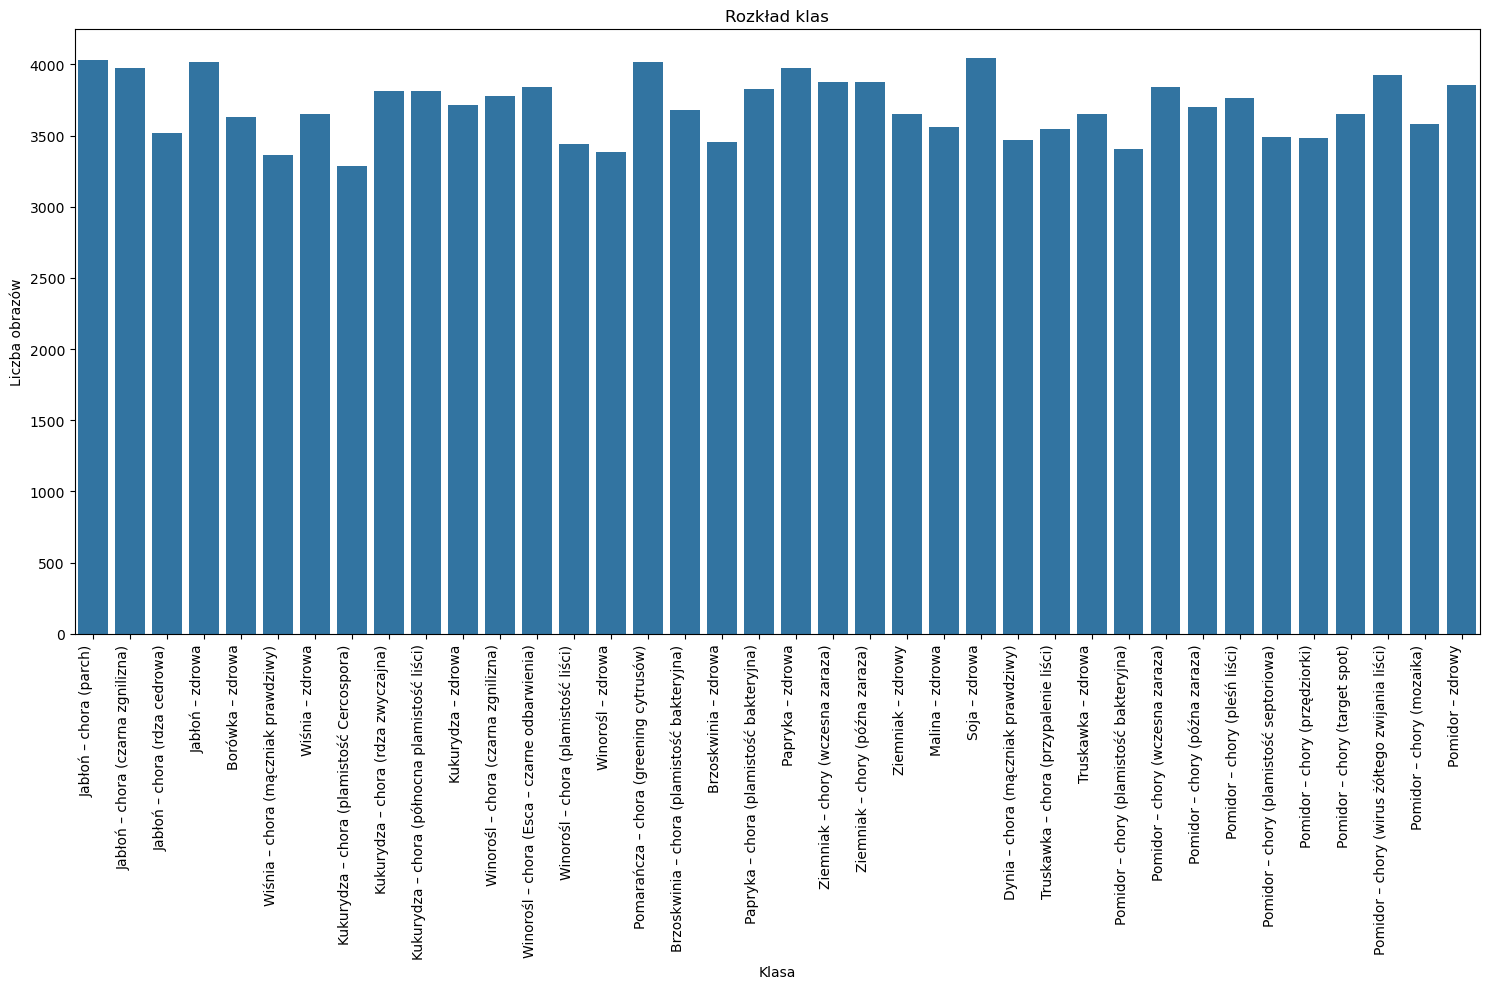

In [33]:
# 5. Rysowanie wykresu słupkowego
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x="Klasa", y="Liczba obrazów")
plt.xticks(rotation=90, ha="right")
plt.title("Rozkład klas")
plt.tight_layout()
plt.show()


In [12]:
#generator treningowy z augmentacją
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Train: {train_data.samples} obrazów w {train_data.num_classes} klasach")
print(f"Valid: {valid_data.samples} obrazów w {valid_data.num_classes} klasach")
print(f"Test:  {test_data.samples} obrazów w {test_data.num_classes} klasach")

Found 140590 images belonging to 38 classes.
Found 34384 images belonging to 38 classes.
Found 760 images belonging to 38 classes.
Train: 140590 obrazów w 38 klasach
Valid: 34384 obrazów w 38 klasach
Test:  760 obrazów w 38 klasach


In [5]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(image_shape[0], image_shape[1], 3)
)
base_model.trainable = False

inputs = Input(shape=(image_shape[0], image_shape[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

model_effnet = Model(inputs=inputs, outputs=outputs)

model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_effnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,877,641 (18.61 MB)

 Trainable params: 826,534 (3.15 MB)

 Non-trainable params: 4,051,107 (15.45 MB)

In [6]:
history_stage1 = model_effnet.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, min_lr=1e-6)
    ]
)

C:\Users\Ania\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5860s 1s/step - accuracy: 0.5207 - loss: 1.9100 - val_accuracy: 0.9396 - val_loss: 0.2954 - learning_rate: 1.0000e-04
Epoch 2/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5774s 1s/step - accuracy: 0.8797 - loss: 0.4853 - val_accuracy: 0.9589 - val_loss: 0.2299 - learning_rate: 1.0000e-04
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5791s 1s/step - accuracy: 0.9162 - loss: 0.3658 - val_accuracy: 0.9619 - val_loss: 0.2130 - learning_rate: 1.0000e-04
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6008s 1s/step - accuracy: 0.9285 - loss: 0.3188 - val_accuracy: 0.9680 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 5/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6871s 2s/step - accuracy: 0.9382 - loss: 0.2873 - val_accuracy: 0.9729 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 6/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5920s 1s/step - accuracy: 0.9453 - loss: 0.2621 - val_accuracy: 0.9754 - val_loss: 0.1642 - learning_rate: 1.0000e-04
Epoch 7/10
4394/4394 ━━━━━━━━━━━━━━━━━━━

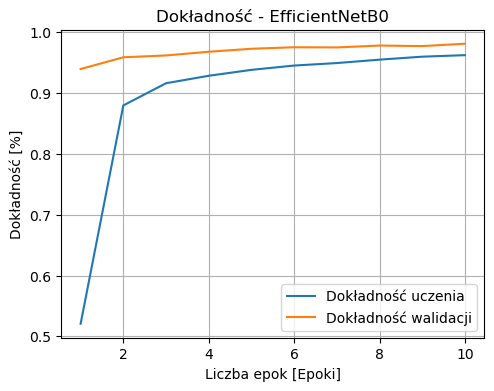

In [5]:
import matplotlib.pyplot as plt

# Rekonstrukcja danych z outputu
accuracy = [0.5207, 0.8797, 0.9162, 0.9285, 0.9382, 0.9453, 0.9494, 0.9550, 0.9599, 0.9624]
val_accuracy = [0.9396, 0.9589, 0.9619, 0.9680, 0.9729, 0.9754, 0.9751, 0.9782, 0.9773, 0.9812]
loss = [1.9100, 0.4853, 0.3658, 0.3188, 0.2873, 0.2621, 0.2468, 0.2269, 0.2121, 0.2021]
val_loss = [0.2954, 0.2299, 0.2130, 0.1914, 0.1777, 0.1642, 0.1635, 0.1564, 0.1532, 0.1422]

epochs = list(range(1, 11))

plt.figure(figsize=(12, 4))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Dokładność uczenia',)
plt.plot(epochs, val_accuracy, label='Dokładność walidacji')
plt.title('Dokładność - EfficientNetB0')
plt.xlabel('Liczba epok [Epoki]')
plt.ylabel('Dokładność [%]')
plt.legend()
plt.grid(True)



In [27]:
# zakładamy, że zmienna model_effnet nadal wskazuje na wytrenowany model
model_effnet.save('efficientnetb0_trained_best.keras')
print("Zapisano model do efficientnetb0_trained_best.keras")


Zapisano model do efficientnetb0_trained_best.keras


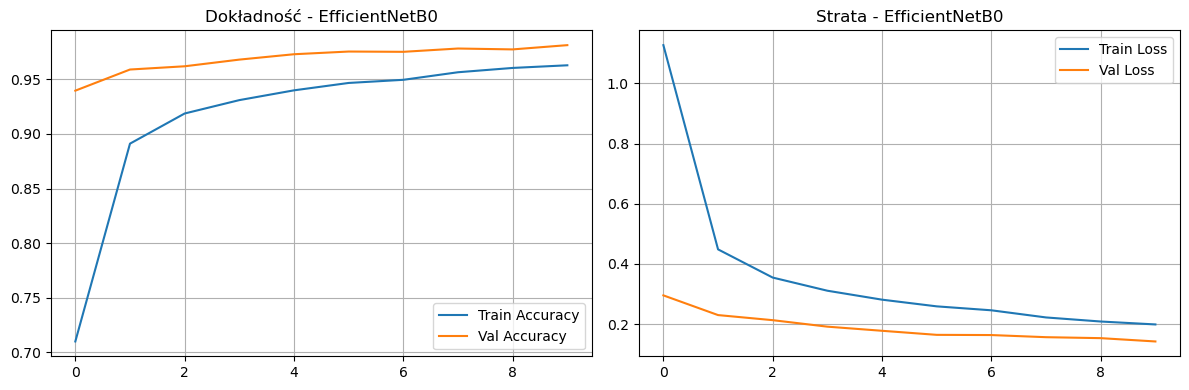

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Val Accuracy')
plt.title('Dokładność - EfficientNetB0')
plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Val Loss')
plt.title('Strata - EfficientNetB0')
plt.legend(), plt.grid()
plt.tight_layout()
plt.show()

In [13]:
loss_1, acc_1 = model_effnet.evaluate(valid_data, verbose=1)
print(f"\nWynik na walidacji po Faza 1 – Accuracy: {acc_1:.4f}, Loss: {loss_1:.4f}")


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 869s 808ms/step - accuracy: 0.9873 - loss: 0.1229

Wynik na walidacji po Faza 1 – Accuracy: 0.9812, Loss: 0.1422


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 976ms/step


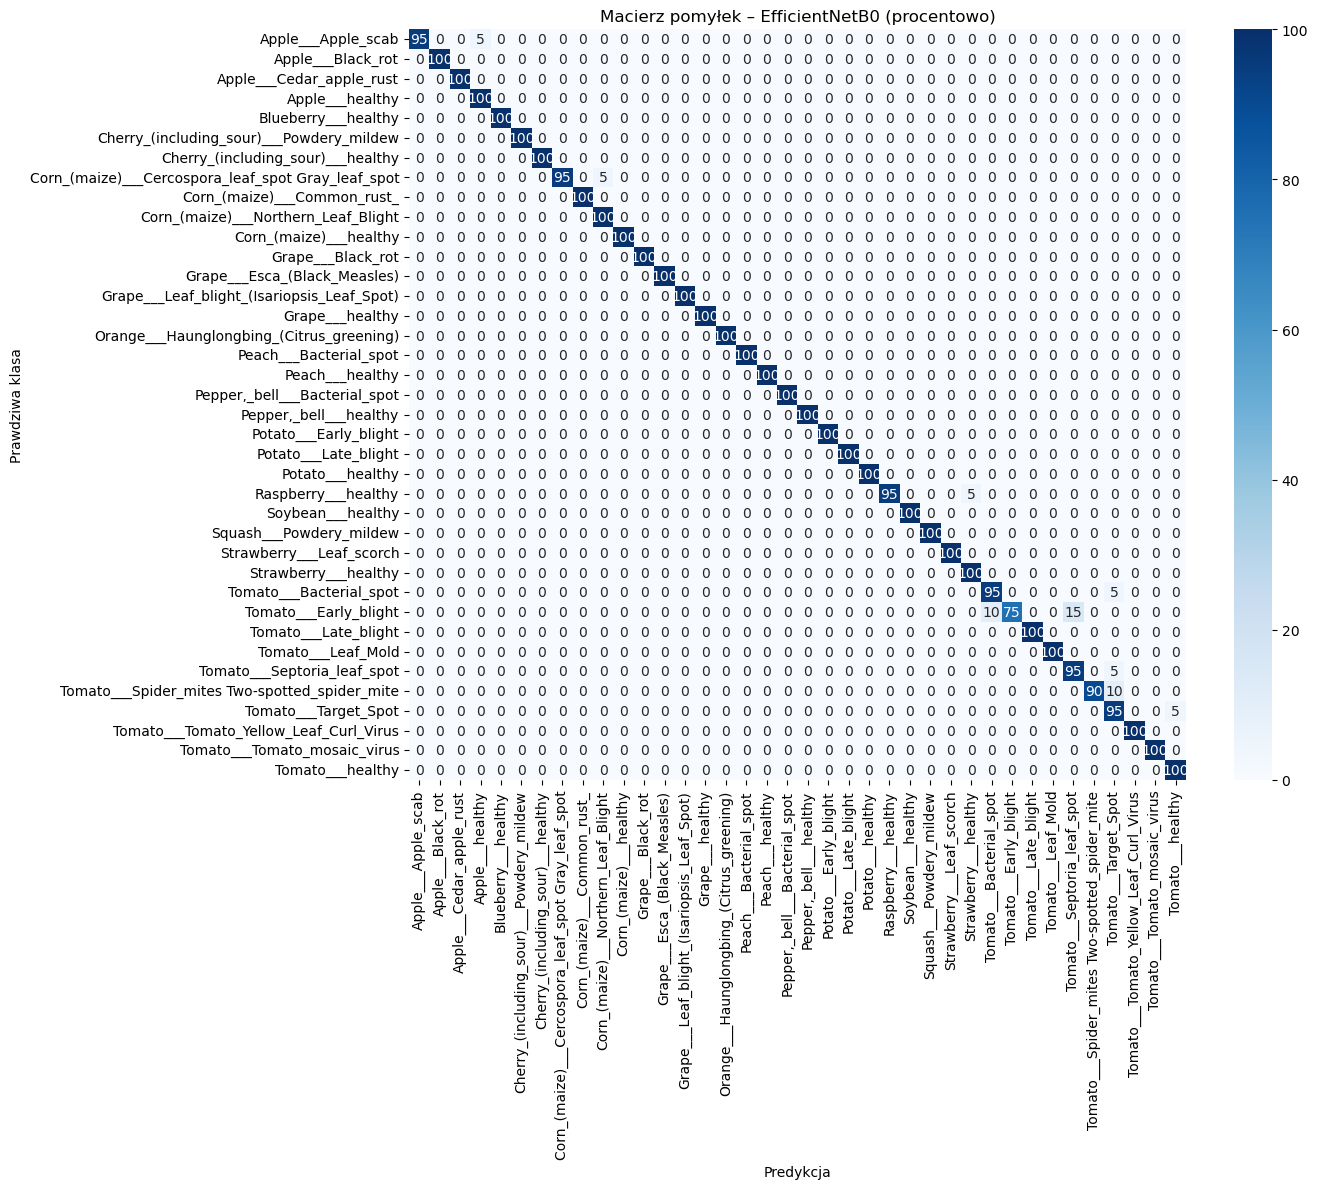


===== Raport klasyfikacji (Precision, Recall, F1) =====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.95      0.97        20
                                 Apple___Black_rot       1.00      1.00      1.00        20
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        20
                                   Apple___healthy       0.95      1.00      0.98        20
                               Blueberry___healthy       1.00      1.00      1.00        20
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        20
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.95      0.97        20
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        20
               Corn_(

In [19]:
y_pred_probas = model_effnet.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred_probas, axis=1)
y_true_classes = test_data.classes

# 8.2. Macierz pomyłek
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # skala procentowa

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=list(test_data.class_indices.keys()),
    yticklabels=list(test_data.class_indices.keys())
)
plt.title("Macierz pomyłek – EfficientNetB0 (procentowo)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.3. Raport metryk (Precision/Recall/F1) na każdej klasie
print("\n===== Raport klasyfikacji (Precision, Recall, F1) =====\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=list(test_data.class_indices.keys())
))

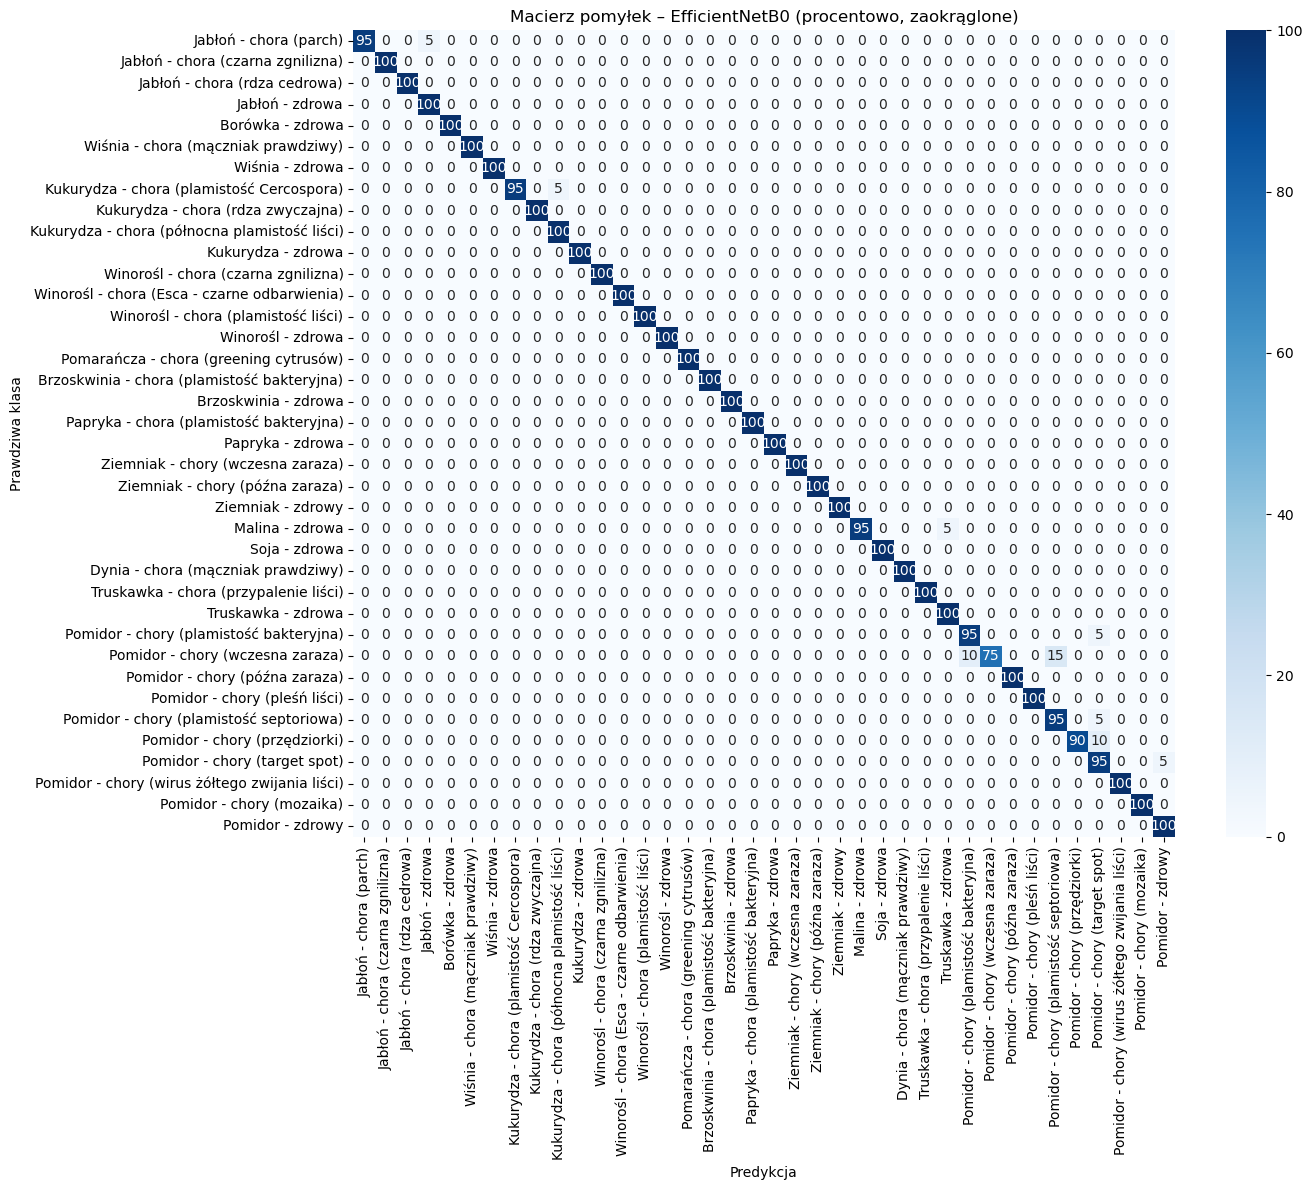

In [41]:
class_names_pl = [
    'Jabłoń - chora (parch)', 'Jabłoń - chora (czarna zgnilizna)', 'Jabłoń - chora (rdza cedrowa)', 'Jabłoń - zdrowa',
    'Borówka - zdrowa', 'Wiśnia - chora (mączniak prawdziwy)', 'Wiśnia - zdrowa',
    'Kukurydza - chora (plamistość Cercospora)', 'Kukurydza - chora (rdza zwyczajna)',
    'Kukurydza - chora (północna plamistość liści)', 'Kukurydza - zdrowa',
    'Winorośl - chora (czarna zgnilizna)', 'Winorośl - chora (Esca - czarne odbarwienia)',
    'Winorośl - chora (plamistość liści)', 'Winorośl - zdrowa',
    'Pomarańcza - chora (greening cytrusów)', 'Brzoskwinia - chora (plamistość bakteryjna)',
    'Brzoskwinia - zdrowa', 'Papryka - chora (plamistość bakteryjna)', 'Papryka - zdrowa',
    'Ziemniak - chory (wczesna zaraza)', 'Ziemniak - chory (późna zaraza)', 'Ziemniak - zdrowy',
    'Malina - zdrowa', 'Soja - zdrowa', 'Dynia - chora (mączniak prawdziwy)',
    'Truskawka - chora (przypalenie liści)', 'Truskawka - zdrowa',
    'Pomidor - chory (plamistość bakteryjna)', 'Pomidor - chory (wczesna zaraza)', 'Pomidor - chory (późna zaraza)',
    'Pomidor - chory (pleśń liści)', 'Pomidor - chory (plamistość septoriowa)',
    'Pomidor - chory (przędziorki)', 'Pomidor - chory (target spot)',
    'Pomidor - chory (wirus żółtego zwijania liści)', 'Pomidor - chory (mozaika)', 'Pomidor - zdrowy'
]

#macierz pomyłek
cm = confusion_matrix(y_true_classes, y_pred_classes)

#normalizowana w % (zaokrąglona)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#pokaż macierz
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=class_names_pl, yticklabels=class_names_pl)
plt.title("Macierz pomyłek – EfficientNetB0 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
from tensorflow.keras.models import load_model

model = load_model("efficientnetb0_trained_best.keras")
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Przewidywane etykiety jako argmax
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Prawdziwe etykiety
y_true = test_data.classes

# Nazwy klas
class_labels = list(test_data.class_indices.keys())

# Raport klasyfikacji
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# Dokładność ogólna
print("Dokładność ogólna:", accuracy_score(y_true, y_pred))

C:\Users\Ania\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 116 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\Ania\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 985ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.9500    0.9744        20
                                 Apple___Black_rot     1.0000    1.0000    1.0000        20
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        20
                                   Apple___healthy     0.9524    1.0000    0.9756        20
                               Blueberry___healthy     1.0000    1.0000    1.0000        20
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        20
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     1.0000    0.9500    0.9744        20
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        20
               Corn_(maize)___Norther